In [1]:
# Credits: https://www.kaggle.com/datasets/crawford/emnist/data?select=emnist-balanced-mapping.txt
# This notebook is based on the above link
# Notebook created by: https://www.kaggle.com/jonathanimmanuel

In [2]:
# Importing the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [8]:
# This mapping is used to map the labels to the actual characters
maps = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "A",
    11: "B",
    12: "C",
    13: "D",
    14: "E",
    15: "F",
    16: "G",
    17: "H",
    18: "I",
    19: "J",
    20: "K",
    21: "L",
    22: "M",
    23: "N",
    24: "O",
    25: "P",
    26: "Q",
    27: "R",
    28: "S",
    29: "T",
    30: "U",
    31: "V",
    32: "W",
    33: "X",
    34: "Y",
    35: "Z",
    36: "a",
    37: "b",
    38: "d",
    39: "e",
    40: "f",
    41: "g",
    42: "h",
    43: "n",
    44: "q",
    45: "r",
    46: "t"
}

# datadir = "./data"
datadir = "./input_emnist"

In [9]:
# Function to import the data
def import_data():
    # Import the data
    train = pd.read_csv(os.path.join(datadir, "emnist-balanced-train.csv"), header=None)
    test = pd.read_csv(os.path.join(datadir, "emnist-balanced-test.csv"), header=None)

    # Split the data
    x_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    x_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values

    # Reshape the data
    x_train = x_train.reshape(x_train.shape[0], 28, 28)
    x_test = x_test.reshape(x_test.shape[0], 28, 28)

    return (x_train, y_train), (x_test, y_test)

In [10]:
# Function to load the data
def load_data():
    (x_train, y_train), (x_test, y_test) = import_data()

    # Normalize the data
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, 47)
    y_test = tf.keras.utils.to_categorical(y_test, 47)

    return (x_train, y_train), (x_test, y_test)

In [11]:
# Let's look at the data
(x_train, y_train), (x_test, y_test) = load_data()
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

x_train: (112800, 28, 28)
y_train: (112800, 47)


In [12]:
# Function to display the data
def display_data(x, y):
    # Display the data
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i], cmap="gray")
        plt.title(maps[np.argmax(y[i])])
        plt.axis("off")
    plt.show()

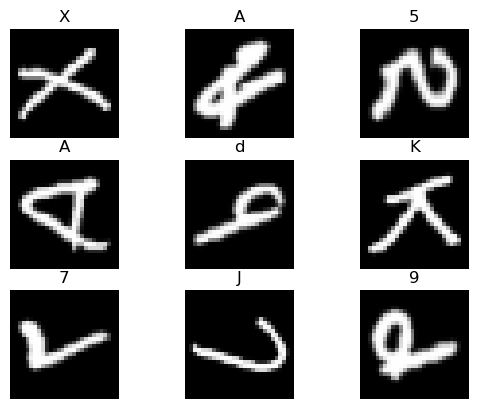

In [13]:
# Display the data randomly
random_sample = np.random.randint(0, x_train.shape[0], 9)
display_data(x_train[random_sample], y_train[random_sample])

In [14]:
# Images are rotated incorrectly and upside down, so we need to rotate them
def rotate_data(x):
    # Rotate the data
    x_rotated = []
    for i in range(x.shape[0]):
        img = Image.fromarray(x[i])
        img = img.rotate(90)
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
        x_rotated.append(np.array(img))
    x_rotated = np.array(x_rotated)

    return x_rotated

In [15]:
# Let's rotate the data
rotated_x_train = rotate_data(x_train)
rotated_x_test = rotate_data(x_test)

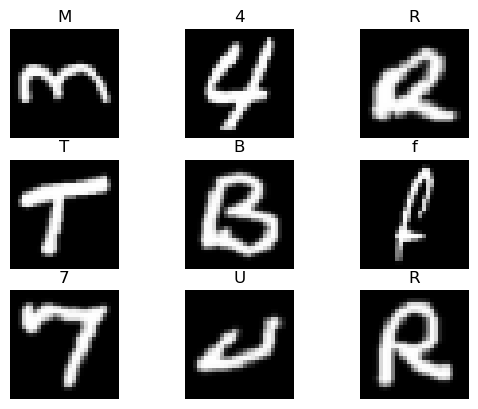

In [16]:
# Display the data randomly
random_sample = np.random.randint(0, rotated_x_train.shape[0], 9)
display_data(rotated_x_train[random_sample], y_train[random_sample])

In [17]:
# Finish the data
dataset = tf.data.Dataset.from_tensor_slices((rotated_x_train, y_train), )
dataset = dataset.shuffle(10000)
dataset = dataset.cache()
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((rotated_x_test, y_test))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

I0000 00:00:1748195856.574607  229907 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4599 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [18]:
# Now that the data looks good, let's build the model
def build_model_dense():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [19]:
# Now that the data looks good, let's build the model
def build_model_conv():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (4, 4), activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((4, 4)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [20]:
# Now that the data looks good, let's build the model
def build_model_conv_full():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [21]:
# Build the model
model_1 = build_model_dense()
model_2 = build_model_conv()
model_3 = build_model_conv_full()
print(model_1.summary())
print(model_2.summary())
print(model_3.summary())

/home/severus/.anaconda/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/severus/.anaconda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,583 (568.68 KB)

 Trainable params: 145,583 (568.68 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,191 (602.31 KB)

 Trainable params: 154,191 (602.31 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 47)             │        75,247 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,063 (367.43 KB)

 Trainable params: 94,063 (367.43 KB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

In [23]:
# Train the model
history1 = model_1.fit(dataset, validation_data=test_dataset, epochs=20, callbacks=callbacks, verbose=2)
history2 = model_2.fit(dataset, validation_data=test_dataset, epochs=20, callbacks=callbacks, verbose=2)
history3 = model_3.fit(dataset, validation_data=test_dataset, epochs=20, callbacks=callbacks, verbose=2)

Epoch 1/20


I0000 00:00:1748195927.786538  239476 service.cc:152] XLA service 0x718b640048f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748195927.786559  239476 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-05-25 20:58:47.818142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748195928.005679  239476 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748195929.936352  239476 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3525/3525 - 11s - 3ms/step - accuracy: 0.6507 - loss: 1.1655 - val_accuracy: 0.7822 - val_loss: 0.6967
Epoch 2/20
3525/3525 - 16s - 5ms/step - accuracy: 0.7515 - loss: 0.7761 - val_accuracy: 0.8070 - val_loss: 0.5996
Epoch 3/20
3525/3525 - 14s - 4ms/step - accuracy: 0.7724 - loss: 0.6958 - val_accuracy: 0.8179 - val_loss: 0.5600
Epoch 4/20
3525/3525 - 11s - 3ms/step - accuracy: 0.7852 - loss: 0.6498 - val_accuracy: 0.8243 - val_loss: 0.5355
Epoch 5/20
3525/3525 - 8s - 2ms/step - accuracy: 0.7915 - loss: 0.6235 - val_accuracy: 0.8235 - val_loss: 0.5262
Epoch 6/20
3525/3525 - 10s - 3ms/step - accuracy: 0.7958 - loss: 0.6104 - val_accuracy: 0.8256 - val_loss: 0.5247
Epoch 7/20
3525/3525 - 11s - 3ms/step - accuracy: 0.8007 - loss: 0.5936 - val_accuracy: 0.8296 - val_loss: 0.5134
Epoch 8/20
3525/3525 - 13s - 4ms/step - accuracy: 0.8042 - loss: 0.5797 - val_accuracy: 0.8327 - val_loss: 0.5101
Epoch 9/20
3525/3525 - 19s - 5ms/step - accuracy: 0.8065 - loss: 0.5710 - val_accuracy: 0.8305 - val

2025-05-25 21:04:34.290037: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.6 = (f32[32,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0} %bitcast.1763, f32[32,1,3,3]{3,2,1,0} %bitcast.1770, f32[32]{0} %bitcast.2162), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_1_1/convolution" source_file="/home/severus/.anaconda/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 21:04:34.393082: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially b

3525/3525 - 19s - 5ms/step - accuracy: 0.7910 - loss: 0.6711 - val_accuracy: 0.8436 - val_loss: 0.4840
Epoch 2/20
3525/3525 - 15s - 4ms/step - accuracy: 0.8601 - loss: 0.4141 - val_accuracy: 0.8600 - val_loss: 0.4205
Epoch 3/20
3525/3525 - 14s - 4ms/step - accuracy: 0.8784 - loss: 0.3511 - val_accuracy: 0.8653 - val_loss: 0.3990
Epoch 4/20
3525/3525 - 16s - 4ms/step - accuracy: 0.8903 - loss: 0.3117 - val_accuracy: 0.8672 - val_loss: 0.3980
Epoch 5/20
3525/3525 - 14s - 4ms/step - accuracy: 0.8986 - loss: 0.2833 - val_accuracy: 0.8672 - val_loss: 0.4063
Epoch 6/20
3525/3525 - 14s - 4ms/step - accuracy: 0.9051 - loss: 0.2609 - val_accuracy: 0.8673 - val_loss: 0.4178
Epoch 7/20
3525/3525 - 15s - 4ms/step - accuracy: 0.9109 - loss: 0.2422 - val_accuracy: 0.8629 - val_loss: 0.4342


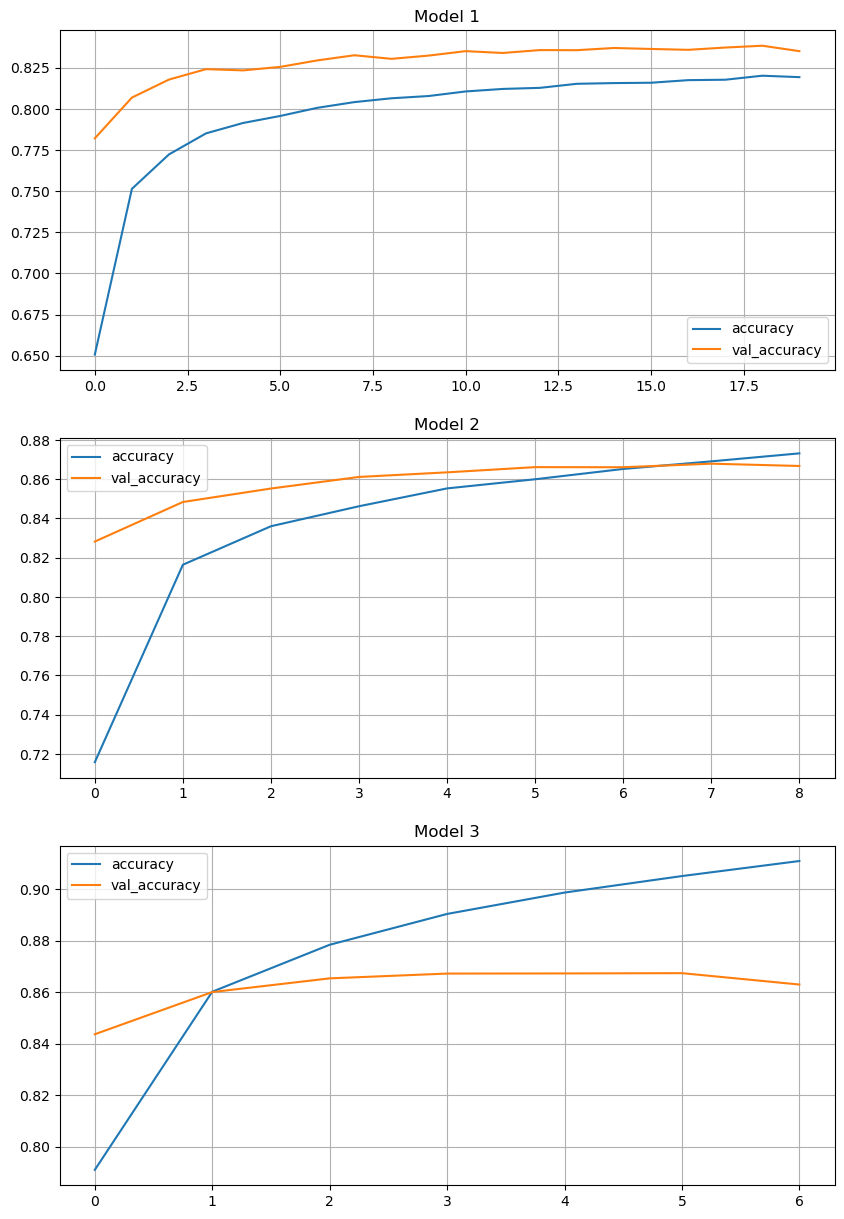

In [24]:
# Plot the accuracy
ax, fig = plt.subplots(3, 1, figsize=(10, 15))
fig[0].plot(history1.history["accuracy"], label="accuracy")
fig[0].plot(history1.history["val_accuracy"], label="val_accuracy")
fig[0].set_title("Model 1")
fig[0].legend()
fig[0].grid()

fig[1].plot(history2.history["accuracy"], label="accuracy")
fig[1].plot(history2.history["val_accuracy"], label="val_accuracy")
fig[1].set_title("Model 2")
fig[1].legend()
fig[1].grid()

fig[2].plot(history3.history["accuracy"], label="accuracy")
fig[2].plot(history3.history["val_accuracy"], label="val_accuracy")
fig[2].set_title("Model 3")
fig[2].legend()
fig[2].grid()

plt.show()

588/588 [==============================] - 7s 10ms/step


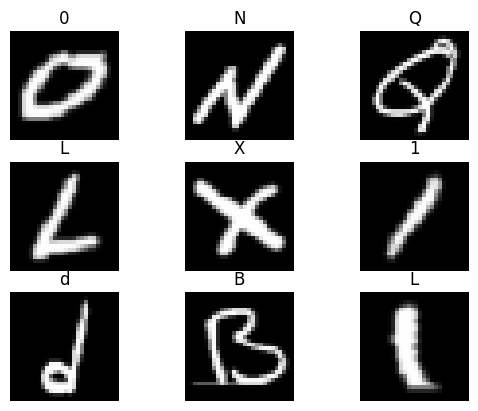

In [22]:
# Display the predictions and the actual values
predictions = model_3.predict(rotated_x_test)
random_sample = np.random.randint(0, rotated_x_test.shape[0], 9)
display_data(rotated_x_test[random_sample], predictions[random_sample])

In [23]:
# It's understandable that some of the images may not be predicted correctly due to similarity in the characters
# But the model is able to predict most of the images correctly

# Save the model
model_3.save("emnist_model.keras")